# Objectif : minimiser le max de la puissance à la racine dans une journée

### Librairies

In [1]:
import pandas as pd
from math import isnan, exp
import numpy as np
from random import randint, uniform, sample
import matplotlib.pyplot as plt
import datetime
from time import time        
from pathlib import Path

### Ouverture des fichiers

In [2]:
file_name_power_limits = "data_opti/limites_puissance.csv"
file_name_consumption_info = "data_opti/info_consommation.csv"
file_name_equipments = "data_opti/equipements.csv"

# Création des df
df_power_limits = pd.read_csv(file_name_power_limits, sep = ';')
df_info_consumption = pd.read_csv(file_name_consumption_info, sep = ';', index_col = 0, decimal = ",")
df_equipments = pd.read_csv(file_name_equipments, sep = ';', index_col = 0, decimal = ",")

# Liste des noms d'équipements et des id de maison
lst_index_logement = list(df_equipments.index.values)
lst_col_equipment = list(df_equipments.columns.values)

# Contraintes Heures creuses
dict_HC = {
    "range1" : {"begin" : "22", "end" : "7"},
    "range2" : {"begin" : '11', "end" : '14'}
}

### Lecture fichier

In [3]:
df_power_limits.head(10)

,min_surface,max_surface,puissance
0,NaN,50.0,3
1,50.0,80.0,6
2,80.0,100.0,9
3,100.0,160.0,12
4,160.0,180.0,15
5,180.0,200.0,25
6,200.0,250.0,30
7,250.0,NaN,36


In [4]:
df_info_consumption.head(10)

,type,puissance,tps_cycle,amperage,hr_debut_hc,hr_debut_hc_nb,hr_max,sequensable
LV,Md1,1.3,1.0,6.0,0,NaN,NaN,N
LL,Md2,2.0,1.0,9.0,0,NaN,NaN,N
SL,Md3,1.0,4.0,4.0,0,NaN,NaN,N
TV,Md4,0.1,1.0,0.5,1,1.0,NaN,N
FG1,Mc1,0.1,0.2,0.5,1,4.0,NaN,N
CE1,Mc2,2.2,6.0,10.0,1,1.0,NaN,O
CG,Mc3,0.1,0.2,0.5,1,4.0,NaN,N
FO,Md5,1.6,1.0,12.0,1,1.0,NaN,N
PL,Md6,1.2,1.0,20.0,1,1.0,NaN,N
FG2,Mc4,0.3,0.2,3.0,1,4.0,NaN,N


In [5]:
df_equipments.head(7)

,LV,LL,SL,TV,FG1,CE1,CG,FO,PL,FG2,CE2
A100-3-1,1,1,1,1,1,1,0,1,1,1,1
A100-3-10,1,1,1,1,1,1,0,1,1,1,0
A100-3-100,1,1,1,1,1,1,0,1,1,0,0
A100-3-101,1,1,0,1,1,1,1,1,1,0,1
A100-3-102,1,1,1,1,1,1,0,1,1,0,0
A100-3-103,1,1,1,1,1,1,1,1,1,1,0
A100-3-104,1,1,0,1,1,1,0,1,1,0,0


### Fonctions

Modification du dataframe d'équipements pour ajouter les informations nécessaires

In [6]:
# Parse le nom de chaque maison Mxxx-yy-zzz ou appartement Axxx-yy-zzz ou 
#    - Xxx : surface (m²)
#    - Yy : nb occupants
#    - Zzz : repère sur le réseau
def parse_name(lst_name_housing : str) -> dict :
    res = {'type' : [], "surface" : [], "occupants" : [], "id" : []}
    
    for str_id in lst_name_housing:
        name_housing = str_id
        if name_housing[0] == "A" : res['type'].append('appartement')
        else : res['type'].append("maison")

        # Surface m²
        name_housing = name_housing[1:]
        stop = name_housing.find("-")
        res["surface"].append(int(name_housing[:stop]))

        # Nb occupants
        name_housing = name_housing[stop + 1:]
        stop = name_housing.find("-")
        res["occupants"].append(int(name_housing[:stop]))

        # Id 
        res["id"].append(name_housing[stop + 1:])
    
    return res

# Définit la consommation max selon la surface en m²
def max_consumption(df_limits, surface) -> int :
    for index, row in df_limits.iterrows():
        bool1 = (row["min_surface"] < surface) if not(isnan(row["min_surface"])) else True
        bool2 = (surface <= row["max_surface"]) if not(isnan(row["max_surface"])) else True
        if bool1 and bool2 : return row["puissance"]
    return None

# Ajoute des information à chaque logement (le type, la surface, sa conso max, le nombre d'occupants et son id de maison)
def add_columns_to_equipment(lst_logement, df_power_limits, df_equipments, df_info_consump):
    dict_house = parse_name(lst_logement)
    #dict_house["max_consumption"] = [max_consumption(df_power_limits, surface_indiv) for surface_indiv in dict_house['surface']]
     
    # Gérer selon la consommation max selon la surface
    dict_house["max_consumption"] = []
    for i in range(len(dict_house['surface'])):
        current_surface = dict_house['surface'][i]
        current_house = lst_logement[i]
        
        # Calcul de la consommation max
        consumption_max = max_consumption(df_power_limits, current_surface)
        # Si l'utilisateur a une TV, on déduit la puissance d'utilisation de la TV de la consommation max par moment
        consumption_max = consumption_max - df_info_consump["puissance"]["TV"] if df_equipments["TV"][current_house] else consumption_max
        
        dict_house["max_consumption"].append(consumption_max)
    
    
    for key in dict_house.keys():
        if key not in list(df_equipments.columns.values):
            df_equipments.insert(loc=len(df_equipments.columns),
                  column=key,
                  value=np.array(dict_house[key]))
        else : df_equipments[key] = np.array(dict_house[key])
             
    del dict_house           
    return df_equipments

Modification du dictionnaire d'horaire

In [7]:
# quand des horaires empiètent sur les journées précédentes, on découpe en deux blocs
def modif_creneau(dict_HC : dict) -> dict :
    new_dict_HC = {}
    i = 1
    for key in dict_HC:
        start = int(dict_HC[key]["begin"])
        stop = int(dict_HC[key]["end"])
        if start > stop :
            new_dict_HC["range" + str(i)] = {"begin" : start, "end" : 23}
            i += 1
            new_dict_HC["range" + str(i)] = {"begin" : 0, "end" : stop}
        else :
            new_dict_HC["range" + str(i)] = {"begin" : start, "end" : stop}
        i += 1
    return(new_dict_HC)

Modification d'un équipement

In [8]:
# choisit un début selon les heures creuses et le temps du cycle
def compute_nb_tot_hc(dict_hc_ : dict, tps_cycle) -> int :                       
    tmp = {}
    i = 0
    for key in dict_hc_:
        start, stop = int(dict_hc_[key]["begin"]), int(dict_hc_[key]["end"])
        if stop - start + 1 >= tps_cycle:  
            tmp[i] = [j for j in range(start, stop + 1)]
            i += 1
    randint_range = randint(0, len(tmp.keys()) - 1) if len(tmp.keys()) > 1 else 0
    index_rand_first = randint(tmp[randint_range][0], tmp[randint_range][-1] - tps_cycle)
    del tmp    
    return index_rand_first

# List of "heures creuses"
def create_list_hc(dict_HC : dict) -> list :
    res = []
    for key in dict_HC:
        for j in range(dict_HC[key]["begin"], dict_HC[key]["end"] + 1):
            res.append(j)
    return res

def create_list_hc_meal(list_hc : dict):
    res = []
    for val in list_hc:
        if (12 <= val and val <= 14) or (19 <= val and val <= 21):
            res.append(val)
    
    return res
    
    
# Création de l'index selon l'équipement
def case_hr(
    res, dict_hc_, df_info_consumption, 
    df_equipment, current_equipment, 
    tps_cycle, str_indiv, power_per_tps): 
    
    ite, ite_max = 0, 1000
    bool_index_ok = False
  
    while (not(bool_index_ok) and ite < ite_max):
        # Cas où c'est un équipement qu'on doit lancer en aléatoire dans les heures creuses
        if df_info_consumption["hr_debut_hc"][current_equipment]:
            # Si le temps du cycle vaut 1 ou moins
            if tps_cycle <= 1:
                nb_repet = int(df_info_consumption["hr_debut_hc_nb"][current_equipment])
                # On récupère les horaires creuses
                lst_hc_complete = create_list_hc(dict_hc_)
                # Cas où il s'agit du four ou de la plaque de cuisson:
                if current_equipment == "PL" or current_equipment == "FO":
                    lst_hc_complete_tmp = create_list_hc_meal(lst_hc_complete)
                    if len(lst_hc_complete_tmp) > 0:
                        lst_hc_complete = lst_hc_complete_tmp.copy()
                        del lst_hc_complete_tmp
                        
                # On récupère nb_repet horaire
                lst_hc_rand = sample(lst_hc_complete, k = nb_repet) # vérifier temps cycle!!!
                                
                # On vérifie que la somme pour chaque heure ne dépasse pas la somme max
                bool_index_ok = np.all([res[i].sum() + power_per_tps <= df_equipment['max_consumption'][str_indiv] for i in lst_hc_rand])           
                lst_index = lst_hc_rand
            # Si le temps du cycle vaut plus de 1
            else :
                # choisit un début selon les heures creuses et le temps du cycle
                index_rand_first = compute_nb_tot_hc(dict_hc_, tps_cycle)
                # On vérifie que la somme pour chaque heure ne dépasse pas la somme max
                bool_index_ok = np.all([res[i].sum() + power_per_tps <= df_equipment['max_consumption'][str_indiv] for i in range(index_rand_first, tps_cycle + index_rand_first)])          
                lst_index = [i for i in range(index_rand_first, tps_cycle + index_rand_first)]
        # Cas où on s'en fiche des heures creuses
        else : 
            index_rand_first = randint(0, 24 - tps_cycle)
            # On vérifie que la somme pour chaque heure ne dépasse pas la somme max
            bool_index_ok = np.all([res[i].sum() + power_per_tps <= df_equipment['max_consumption'][str_indiv] for i in range(index_rand_first, tps_cycle + index_rand_first)])          
            lst_index = [i for i in range(index_rand_first, tps_cycle + index_rand_first)]
        ite += 1

    return bool_index_ok, lst_index

Génération de la population

In [9]:
# TODO : enlever la matrice
def generate_matrice_indiv(
    dict_hc : dict,
    str_indiv : str, 
    df_equipment : pd.DataFrame, 
    df_info_consumption : pd.DataFrame, 
    lst_col : list) -> np.array :
    
    col_name = [i for i in range(0, 24)]
    index_name, lst_tmp_info = [], []
    
    for i in range(len(lst_col)):
        if df_equipment[lst_col[i]][str_indiv] and lst_col[i] != "TV":
            index_name.append(lst_col[i])
            lst_tmp_info.append([df_info_consumption["tps_cycle"][lst_col[i]], df_info_consumption["puissance"][lst_col[i]]])
    lst_tmp_info = np.array(lst_tmp_info).T
    df_info_tmp = pd.DataFrame(lst_tmp_info, columns = index_name, index = ["tps_cycle", "puissance"])

    i = 0    
    # Initialisation du résultat  
    res = pd.DataFrame(np.zeros(shape = (len(index_name), 24)), columns = col_name, index = index_name)
    len_lst_equipment_init = len(list(df_info_tmp.columns.values))
    
    while i < len_lst_equipment_init and any([val >= 0 for val in df_info_tmp.loc["tps_cycle"]]):
        lst_equipment_name = list(df_info_tmp.columns.values)
        tps_cycle_argmax = np.argmax(df_info_tmp.loc["tps_cycle"])
        tps_cycle_max = int(np.max(df_info_tmp.loc["tps_cycle"])) 
        if float(np.max(df_info_tmp.loc["tps_cycle"])) - int(np.max(df_info_tmp.loc["tps_cycle"])) > 0:
            tps_cycle_max = tps_cycle_max + 1
        current_equipment = lst_equipment_name[tps_cycle_argmax]
        power_per_tps = df_info_tmp[current_equipment]["puissance"] / tps_cycle_max
        bool_index_ok, lst_index = case_hr(res, dict_hc, df_info_consumption, df_equipment, current_equipment, tps_cycle_max, str_indiv, power_per_tps)

        if bool_index_ok:
            for j in lst_index:
                res[j][current_equipment] = power_per_tps
            df_info_tmp = df_info_tmp.drop(columns = [current_equipment])
        i += 1

    del df_info_tmp, index_name, col_name, lst_tmp_info # Libérer l'espace
    return res

def generer_pop(lst_index, new_dict_HC, df_equipments_short, df_info_consumption, lst_col):
    dict_index_matrix = {}
    sum_by_hour =  np.zeros(shape = (24,))

    i = 0
    start_time = time()
    for index in lst_index:
        dict_index_matrix[index] = generate_matrice_indiv(new_dict_HC, index, df_equipments_short, df_info_consumption, lst_col)
        sum_by_hour = np.add(sum_by_hour, np.array(dict_index_matrix[index].sum()))
        i += 1
    
    return(dict_index_matrix, sum_by_hour)

Modification d'un emploi du temps

In [10]:
def generate_neighbor(current_X, sum_per_hour, df_info_consumption, df_equipment, dict_hc_):
    # prendre un logement random
    lst_index = list(current_X.keys())
    logement_rand = sample(lst_index, k = 1)[0]
    
    # prendre un équipement random
    list_equipment = list(current_X[logement_rand].index.values)
    equipment_rand = list(current_X[logement_rand].index.values)[randint(0, len(list_equipment) - 1)]

    X_log_equip =  current_X[logement_rand].loc[equipment_rand].copy()
    sum_per_hour_to_add = np.zeros((24,))

    for index, item in X_log_equip.iteritems():
        sum_per_hour_to_add[index] -= item
        X_log_equip[index] = 0
    
    # Récuperer les données 
    tps_cycle = int(df_info_consumption["tps_cycle"][equipment_rand])
    power_per_tps = df_info_consumption["puissance"][equipment_rand] / tps_cycle if tps_cycle != 0 else df_info_consumption["puissance"][equipment_rand]
    
    # modifier les horaires selon les contraintes existantes
    bool_index_ok, lst_index = case_hr(current_X[logement_rand], dict_hc_, df_info_consumption, df_equipment, equipment_rand, tps_cycle, logement_rand, power_per_tps)    
    
    if bool_index_ok:
        for j in lst_index:
            X_log_equip[j] = power_per_tps
            sum_per_hour_to_add[j] += power_per_tps
        sum_per_hour = np.add(sum_per_hour, sum_per_hour_to_add)
        current_X[logement_rand].loc[equipment_rand] = X_log_equip.copy()

    return(current_X, sum_per_hour)    

Critère de metropolis et calcul de l'évaluation

In [11]:
def metropolis(new_eval, best_eval, T):
    deltaF = abs(new_eval - best_eval)
    return(new_eval < best_eval or uniform(0, 1) < exp(-deltaF/T))

# Calculer la somme de chaque puissance selon l'heure et déduire le max
def compute_objective(sum_by_hour : np.array) -> float :
    return (np.max(sum_by_hour))

Affichage du graphique

In [12]:
# Affiche la somme des puissances utilisée pour chaque maison selon l'heure
def create_fig(x, y):
    plt.plot(x,y)
    plt.xlabel('Heures')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Puissance à la racine (kW)')
    plt.title("Puissance utilisée (kW) à la racine dans la journée")
    plt.show()

Algo PASA 1

In [13]:
# Fonction principale PASA
def PASA1(T, IterMax, Tmin, Palier, Alpha, lst_index, new_dict_HC, df_equipments_short, df_info_consumption, lst_col):
    # Générer pop
    print("départ : ")
    start_time1 = time()
    best_x, sum_by_hour = generer_pop(lst_index, new_dict_HC, df_equipments_short, df_info_consumption, lst_col)
    print("---Temps génération pop : %s seconds ---" % (time() - start_time1))

    # Calculer une première évaluation et la considérer comme la meilleure
    best_evaluation = np.max(sum_by_hour)
        
    # TODO : supprr
    list_best_eval = [best_evaluation]
    y = list(sum_by_hour)
    x = [datetime.time(i).strftime("%I:00 %p") for i in range(0, 24)]
    create_fig(x, y)  
    
    print("Première évaluation : ", best_evaluation)
    print("Somme = ", np.sum(sum_by_hour))

    # Boucle PASA
    iterPalier = Palier
    iter_courant = 0
    
    start_time = time()
    while(T > Tmin) and (iter_courant < IterMax):
        while (iterPalier > 0):
            # Générer un nouveau X
            new_x, new_sum_by_hour = generate_neighbor(best_x, sum_by_hour, df_info_consumption, df_equipments_short, new_dict_HC)
            # Calculer le nouvel objectif
            new_evaluation = np.max(new_sum_by_hour)
            
            # Si critère métropolis :  
            if metropolis(new_evaluation, best_evaluation, T):
                # enregistrer le nouveau X et son évaluation
                best_x = new_x.copy()
                best_evaluation = new_evaluation
                sum_by_hour = new_sum_by_hour
                list_best_eval.append(best_evaluation) # TODO : suprr
                
            iterPalier -= 1

                
        T = T*Alpha # faire diminuer T <=> refroidissement
        iter_courant += 1 # incrémenter nb itération
        iterPalier = Palier
        
        
    print("---Temps boucle PASA : %s seconds ---" % (time() - start_time))
    print("---Temps total PASA : %s seconds ---" % (time() - start_time1))     
    plt.plot(list_best_eval)
    plt.ylabel('Best eval')
    plt.title("Meilleures évaluations")
    plt.show()

    print("Dernière évaluation : ",best_evaluation)
    print("Somme = ", np.sum(sum_by_hour))

    return (best_x, best_evaluation, sum_by_hour)

Algorithme principal PASA

In [34]:
# Fonction principale PASA
def PASA(best_x, sum_by_hour, T, IterMax, Tmin, Palier, Alpha, lst_index, new_dict_HC, df_equipments_short, df_info_consumption, lst_col):
    # Calculer une première évaluation et la considérer comme la meilleure
    best_evaluation = np.max(sum_by_hour)
        
    # TODO : supprr
    list_best_eval = [best_evaluation]
    y = list(sum_by_hour)
    x = [datetime.time(i).strftime("%I:00 %p") for i in range(0, 24)]
    create_fig(x, y)  
    
    print("Première évaluation : ", best_evaluation)
    print("Somme = ", np.sum(sum_by_hour))

    # Boucle PASA
    iterPalier = Palier
    iter_courant = 0
    
    start_time = time()
    while(T > Tmin) and (iter_courant < IterMax):
        if iter_courant % 1000 == 0:
            print("iter_courant : ", iter_courant, " // T = ", T)
        while (iterPalier > 0):
            # Générer un nouveau X
            new_x, new_sum_by_hour = generate_neighbor(best_x, sum_by_hour, df_info_consumption, df_equipments_short, new_dict_HC)
            # Calculer le nouvel objectif
            new_evaluation = np.max(new_sum_by_hour)
            
            # Si critère métropolis :  
            if metropolis(new_evaluation, best_evaluation, T):
                # enregistrer le nouveau X et son évaluation
                best_x = new_x.copy()
                best_evaluation = new_evaluation
                sum_by_hour = new_sum_by_hour
                list_best_eval.append(best_evaluation) # TODO : suprr
                
            iterPalier -= 1

                
        T = T*Alpha # faire diminuer T <=> refroidissement
        iter_courant += 1 # incrémenter nb itération
        iterPalier = Palier
        
        
    print("---Temps boucle PASA : %s seconds ---" % (time() - start_time))
    
    plt.plot(list_best_eval)
    plt.ylabel('Best eval')
    plt.title("Meilleures évaluations")
    plt.show()

    print("Dernière évaluation : ",best_evaluation)
    print("Somme = ", np.sum(sum_by_hour))

    return (best_x, best_evaluation, sum_by_hour)

In [15]:
"""def equipment_to_binary_list(df_equipment):
    lst_logement_name = list(df_equipment.index.values)
    lst_equipment_name = list(df_equipment.columns.values)
    dict_res = {}
    
    for logement, row in df_equipment.iterrows():
        dict_res[logement] = ""
        for equipment in lst_logement_name:
            dict_res[logement] += "1" if row[equipment] else "0"
    
    return dict_res

def find_path_of_house(dict_owned_equiment, dict_, surface, dict_conv_equip_name):
    binary_str = ""
        for equipment in lst_logement_name:
            binary_str += "1" if dict_conv_equip_name[equipment] else "0"
    
    path = "data_opti/RC_opti/" + str(surface) + "/" + binary_str
    return path
            
    # utiliser la fonction de thomas !!
    #dict_conv_equip_name()"""

def equipment_to_binary_name(df_equipment, name_house):
    res = ""
    for equipment in df_equipment:
        if df_equipment[equipment][name_house] : res += "1"
        else : res += "0"
    return res

def save_matrix_to_csv(best_X, df_equipment, repertory_number : str):
    for name_house in best_X:
        
        res = parse_name([name_house])
        #res = {'type' : [], "surface" : [], "occupants" : [], "id" : []}
        type_, surface_, occ_, _id = res['type'][0], res['surface'][0], res['occupants'][0], res['id'][0]
        
        res_binary = equipment_to_binary_name(df_equipment, name_house)
        
        
        #creating a new directory called pythondirectory
        path_name = "data_opti/res_opti" + str(repertory_number) + "/" + str(surface_) + "/" + res_binary
        Path(path_name).mkdir(parents=True, exist_ok=True)

        path_name += "/" + name_house + ".csv"
        print(path_name)
        # enregistrer en df to csv
        #best_X[name_house].to_csv(path_name, sep=';', encoding='utf-8')
    



### Paramètres du recuit

In [15]:
T0 = 1e9 # temperature initiale
Tmin = 1e-9 # temperature finale
tau = 1e4 # constante pour la décroissance de temperature
Alpha = 0.999 # constante pour la décroissance géométrique
Palier = 7 # nombre d'itérations sur un palier de température
IterMax = 1e9 # nombre max d'itérations de l'algorithme

### Initialisation

##### Modification des heures creuses

In [16]:
# Avant modif heure creuse
print(dict_HC)
# Après modif heure creuse
new_dict_HC = modif_creneau(dict_HC)
print(new_dict_HC)

{'range1': {'begin': '22', 'end': '7'}, 'range2': {'begin': '11', 'end': '14'}}
{'range1': {'begin': 22, 'end': 23}, 'range2': {'begin': 0, 'end': 7}, 'range3': {'begin': 11, 'end': 14}}


### Fonction principale PASA

idée : 
- premier algo PASA "bête" : optimiser un param d'une maison
- deuxième algo PASA : optimiser un param de chaque noeud 
- tester algo multi agent NSGA

In [17]:
"""#df_equipments_short = df_equipments[:10000]
df_equipments_short = df_equipments[:1000]
lst_index_logement = list(df_equipments_short.index.values)
lst_col_equipment = list(df_equipments_short.columns.values)

dict_house = parse_name(lst_index_logement)
dict_house["max_consumption"] = [max_consumption(df_power_limits, surface_indiv) for surface_indiv in dict_house['surface']]

for key in dict_house.keys():
    if key not in list(df_equipments_short.columns.values):
        df_equipments_short.insert(loc=len(df_equipments_short.columns),
              column=key,
              value=np.array(dict_house[key]))
    else : df_equipments_short[key] = np.array(dict_house[key])

best_x, best_evaluation, sum_by_hour = PASA1(T0, IterMax, Tmin, Palier, Alpha, lst_index_logement, new_dict_HC, df_equipments_short, df_info_consumption, lst_col_equipment)

print(best_evaluation)

# Générer un premier dictionnaire de matrice et déterminer la somme de chaque
y = list(sum_by_hour)
x = [datetime.time(i).strftime("%I:00 %p") for i in range(0, 24)]

create_fig(x, y)  
print(sum_by_hour)
"""

'#df_equipments_short = df_equipments[:10000]\ndf_equipments_short = df_equipments[:1000]\nlst_index_logement = list(df_equipments_short.index.values)\nlst_col_equipment = list(df_equipments_short.columns.values)\n\ndict_house = parse_name(lst_index_logement)\ndict_house["max_consumption"] = [max_consumption(df_power_limits, surface_indiv) for surface_indiv in dict_house[\'surface\']]\n\nfor key in dict_house.keys():\n    if key not in list(df_equipments_short.columns.values):\n        df_equipments_short.insert(loc=len(df_equipments_short.columns),\n              column=key,\n              value=np.array(dict_house[key]))\n    else : df_equipments_short[key] = np.array(dict_house[key])\n\nbest_x, best_evaluation, sum_by_hour = PASA1(T0, IterMax, Tmin, Palier, Alpha, lst_index_logement, new_dict_HC, df_equipments_short, df_info_consumption, lst_col_equipment)\n\nprint(best_evaluation)\n\n# Générer un premier dictionnaire de matrice et déterminer la somme de chaque\ny = list(sum_by_hour

### Initialisation : optimisation par palier

---------------------
(start, stop) = (0, 1500)


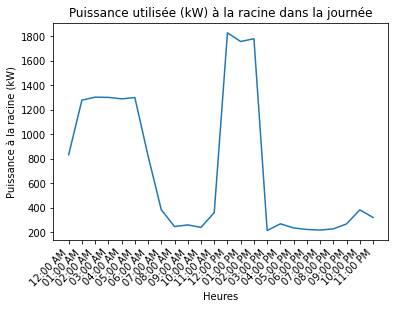

Première évaluation :  1828.4999999999955
Somme =  17346.799999999967
iter_courant :  0  // T =  1000000000.0
iter_courant :  10000  // T =  45173.345977048186
iter_courant :  20000  // T =  2.040631186762097
iter_courant :  30000  // T =  9.218213861115893e-05
iter_courant :  40000  // T =  4.164175640386101e-09
---Temps boucle PASA : 264.29064869880676 seconds ---


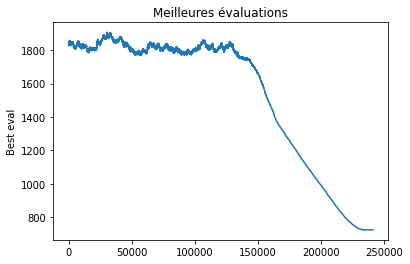

Dernière évaluation :  723.00000000001
Somme =  17346.80000000015
Apres PASA


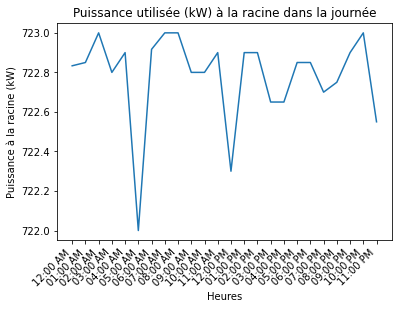

723.00000000001
---------------------
(start, stop) = (1500, 3000)


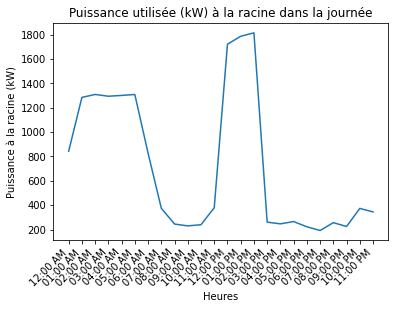

Première évaluation :  1814.2999999999943
Somme =  17352.799999999967
iter_courant :  0  // T =  1000000000.0
iter_courant :  10000  // T =  45173.345977048186
iter_courant :  20000  // T =  2.040631186762097
iter_courant :  30000  // T =  9.218213861115893e-05
iter_courant :  40000  // T =  4.164175640386101e-09
---Temps boucle PASA : 292.57626008987427 seconds ---


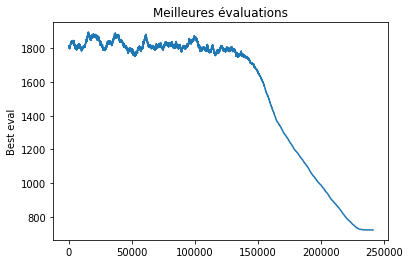

Dernière évaluation :  723.2500000000341
Somme =  17352.80000000013
Apres PASA


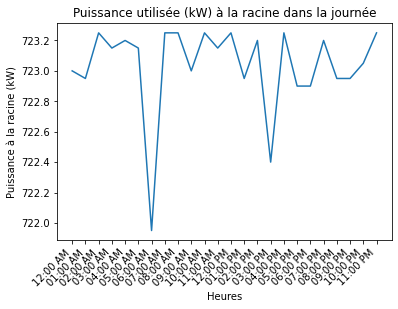

723.2500000000341
---------------------
(start, stop) = (3000, 4500)


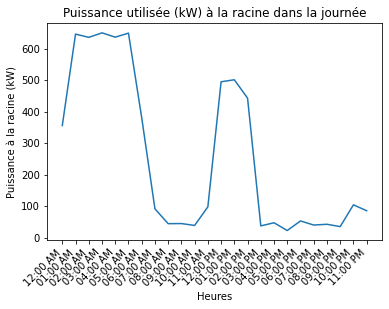

Première évaluation :  649.7000000000038
Somme =  6180.0000000000255
iter_courant :  0  // T =  1000000000.0
iter_courant :  10000  // T =  45173.345977048186
iter_courant :  20000  // T =  2.040631186762097
iter_courant :  30000  // T =  9.218213861115893e-05
iter_courant :  40000  // T =  4.164175640386101e-09
---Temps boucle PASA : 345.66295099258423 seconds ---


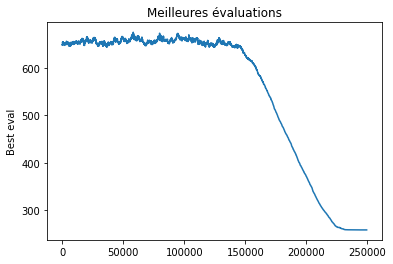

Dernière évaluation :  258.0
Somme =  6179.999999999961
Apres PASA


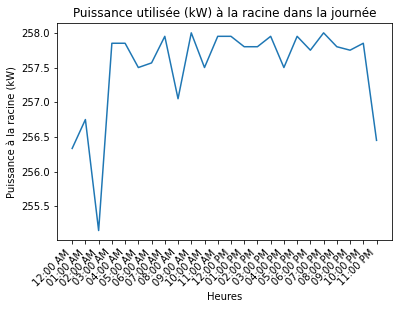

258.0
---------------------
(start, stop) = (4500, 6000)


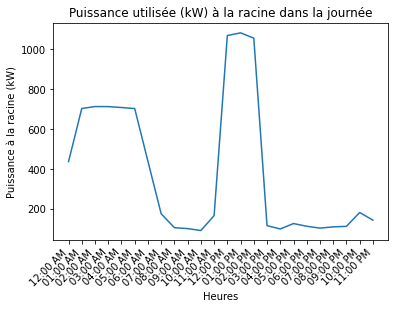

Première évaluation :  1083.0500000000068
Somme =  9406.000000000044
iter_courant :  0  // T =  1000000000.0
iter_courant :  10000  // T =  45173.345977048186
iter_courant :  20000  // T =  2.040631186762097
iter_courant :  30000  // T =  9.218213861115893e-05
iter_courant :  40000  // T =  4.164175640386101e-09
---Temps boucle PASA : 499.68534803390503 seconds ---


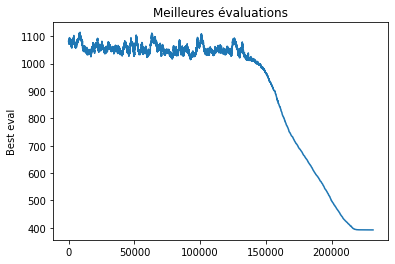

Dernière évaluation :  392.0500000000075
Somme =  9406.000000000005
Apres PASA


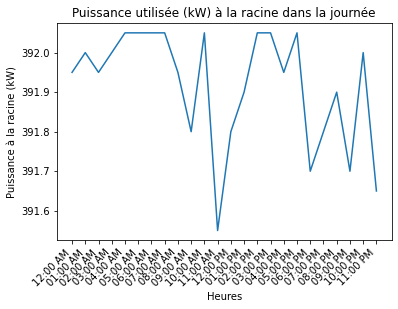

392.0500000000075
---------------------
(start, stop) = (6000, 7500)


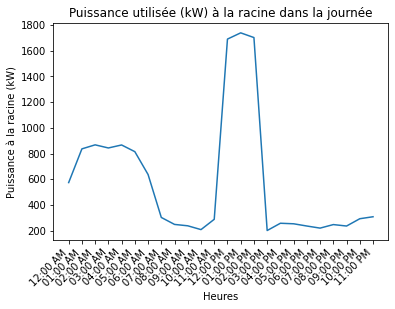

Première évaluation :  1738.9999999999945
Somme =  14110.40000000003
iter_courant :  0  // T =  1000000000.0
iter_courant :  10000  // T =  45173.345977048186
iter_courant :  20000  // T =  2.040631186762097
iter_courant :  30000  // T =  9.218213861115893e-05
iter_courant :  40000  // T =  4.164175640386101e-09
---Temps boucle PASA : 717.4422788619995 seconds ---


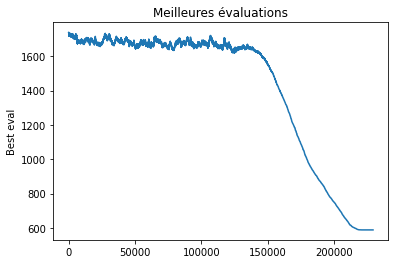

Dernière évaluation :  588.1000000000371
Somme =  14110.40000000022
Apres PASA


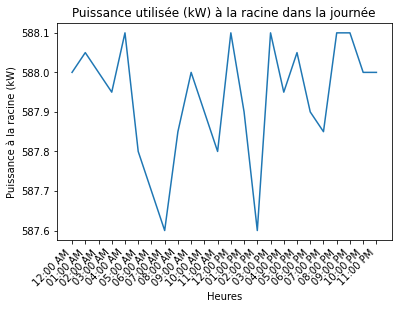

588.1000000000371
---------------------
(start, stop) = (7500, 9000)


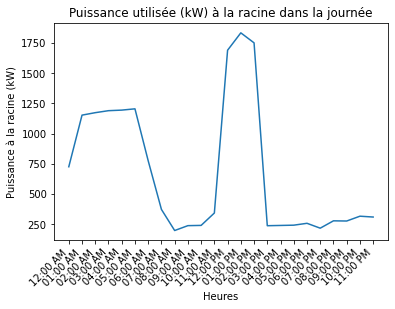

Première évaluation :  1834.7999999999947
Somme =  16471.999999999985
iter_courant :  0  // T =  1000000000.0
iter_courant :  10000  // T =  45173.345977048186
iter_courant :  20000  // T =  2.040631186762097
iter_courant :  30000  // T =  9.218213861115893e-05
iter_courant :  40000  // T =  4.164175640386101e-09
---Temps boucle PASA : 280.94661378860474 seconds ---


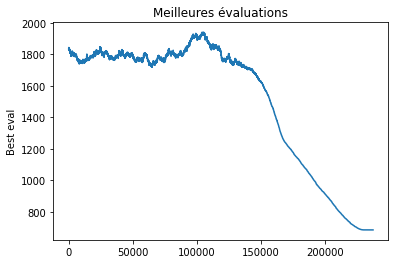

Dernière évaluation :  686.4500000000032
Somme =  16472.00000000015
Apres PASA


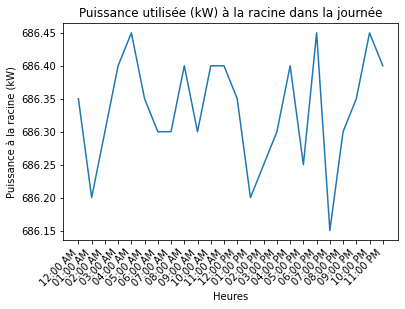

686.4500000000032
---------------------
(start, stop) = (9000, 10500)


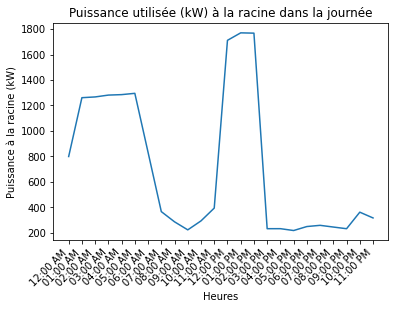

Première évaluation :  1770.5499999999952
Somme =  17175.199999999968
iter_courant :  0  // T =  1000000000.0
iter_courant :  10000  // T =  45173.345977048186
iter_courant :  20000  // T =  2.040631186762097
iter_courant :  30000  // T =  9.218213861115893e-05
iter_courant :  40000  // T =  4.164175640386101e-09
---Temps boucle PASA : 214.81596899032593 seconds ---


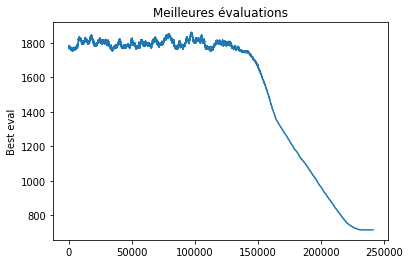

Dernière évaluation :  715.9500000000347
Somme =  17175.200000000135
Apres PASA


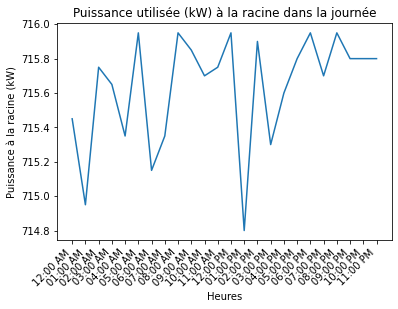

715.9500000000347
---------------------
(start, stop) = (10500, 12000)


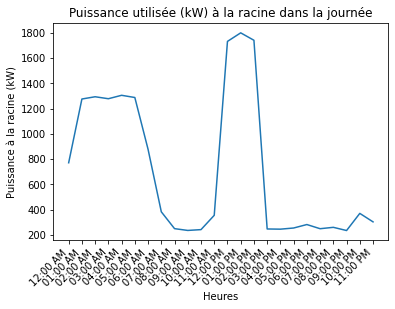

Première évaluation :  1800.8499999999915
Somme =  17277.999999999956
iter_courant :  0  // T =  1000000000.0
iter_courant :  10000  // T =  45173.345977048186
iter_courant :  20000  // T =  2.040631186762097
iter_courant :  30000  // T =  9.218213861115893e-05
iter_courant :  40000  // T =  4.164175640386101e-09
---Temps boucle PASA : 243.8208351135254 seconds ---


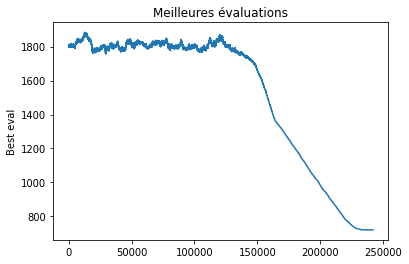

Dernière évaluation :  720.1999999999991
Somme =  17278.000000000135
Apres PASA


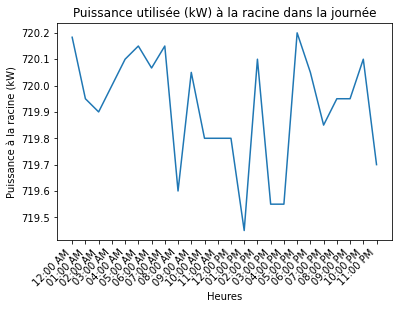

720.1999999999991
---------------------
(start, stop) = (12000, 13500)


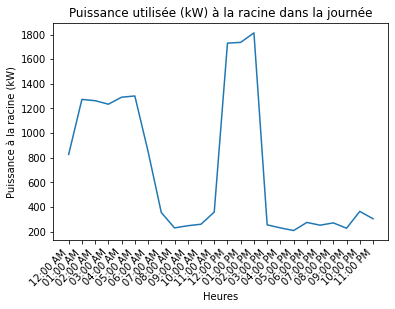

Première évaluation :  1813.7499999999907
Somme =  17177.79999999996
iter_courant :  0  // T =  1000000000.0
iter_courant :  10000  // T =  45173.345977048186
iter_courant :  20000  // T =  2.040631186762097
iter_courant :  30000  // T =  9.218213861115893e-05
iter_courant :  40000  // T =  4.164175640386101e-09
---Temps boucle PASA : 260.2276577949524 seconds ---


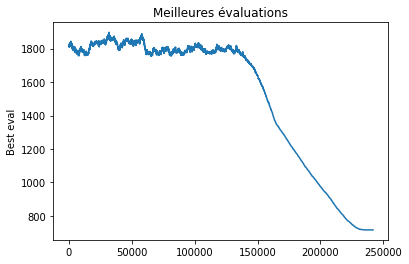

Dernière évaluation :  716.0000000000299
Somme =  17177.80000000012
Apres PASA


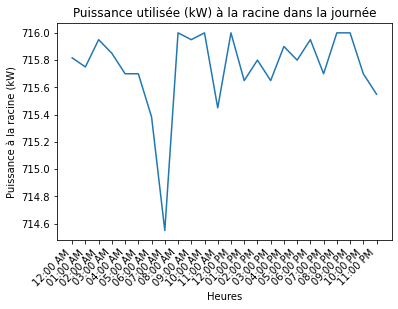

716.0000000000299
---------------------
(start, stop) = (13500, 15000)


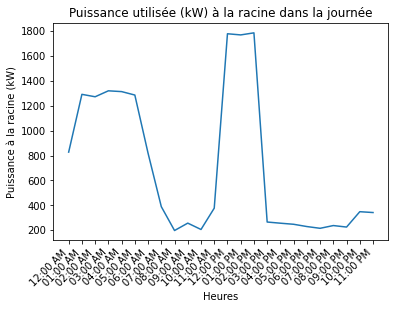

Première évaluation :  1786.6999999999937
Somme =  17261.99999999995
iter_courant :  0  // T =  1000000000.0
iter_courant :  10000  // T =  45173.345977048186
iter_courant :  20000  // T =  2.040631186762097
iter_courant :  30000  // T =  9.218213861115893e-05
iter_courant :  40000  // T =  4.164175640386101e-09
---Temps boucle PASA : 260.5143780708313 seconds ---


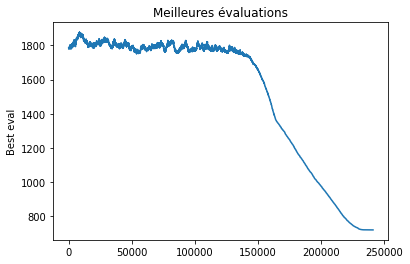

Dernière évaluation :  719.449999999999
Somme =  17262.00000000012
Apres PASA


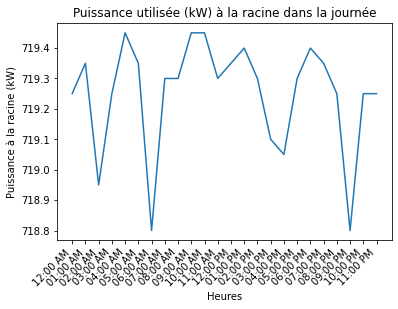

719.449999999999
---------------------
(start, stop) = (15000, 16500)


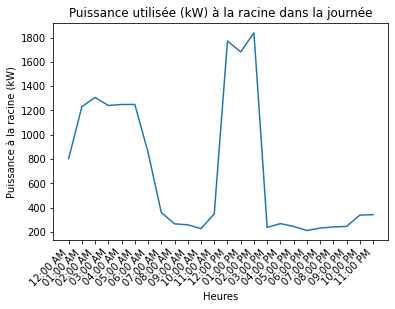

Première évaluation :  1838.6999999999941
Somme =  17058.99999999996
iter_courant :  0  // T =  1000000000.0
iter_courant :  10000  // T =  45173.345977048186
iter_courant :  20000  // T =  2.040631186762097
iter_courant :  30000  // T =  9.218213861115893e-05
iter_courant :  40000  // T =  4.164175640386101e-09
---Temps boucle PASA : 308.0497679710388 seconds ---


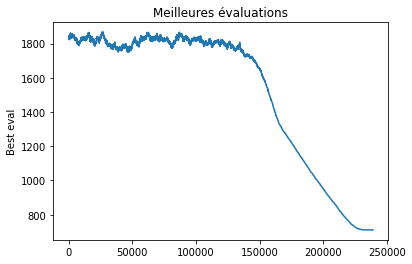

Dernière évaluation :  711.0000000000108
Somme =  17059.00000000013
Apres PASA


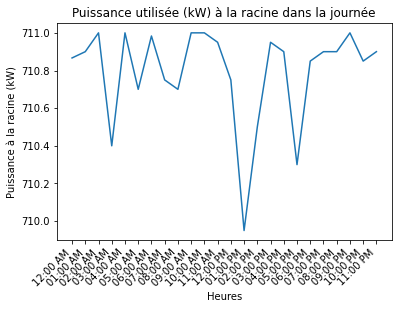

711.0000000000108
---------------------
(start, stop) = (16500, 18000)


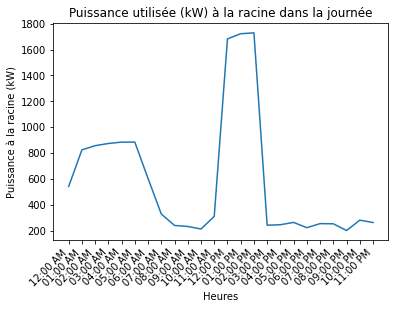

Première évaluation :  1729.9999999999918
Somme =  14143.000000000033
iter_courant :  0  // T =  1000000000.0
iter_courant :  10000  // T =  45173.345977048186
iter_courant :  20000  // T =  2.040631186762097
iter_courant :  30000  // T =  9.218213861115893e-05
iter_courant :  40000  // T =  4.164175640386101e-09
---Temps boucle PASA : 454.21698355674744 seconds ---


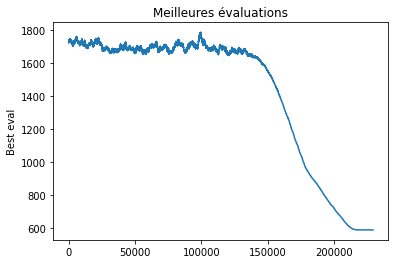

Dernière évaluation :  589.5000000000003
Somme =  14143.000000000218
Apres PASA


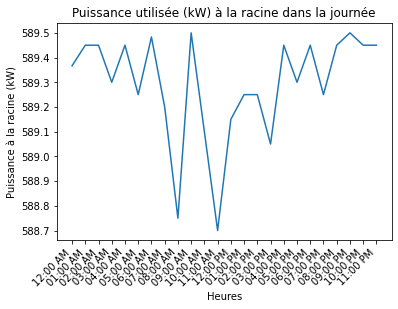

589.5000000000003
---------------------
(start, stop) = (18000, 19500)


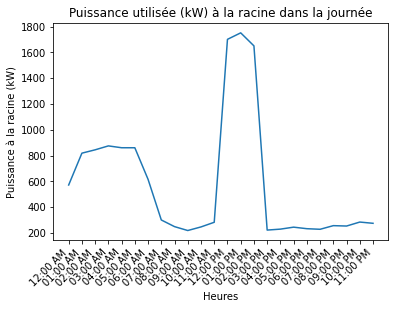

Première évaluation :  1751.949999999992
Somme =  14091.600000000026
iter_courant :  0  // T =  1000000000.0
iter_courant :  10000  // T =  45173.345977048186
iter_courant :  20000  // T =  2.040631186762097
iter_courant :  30000  // T =  9.218213861115893e-05
iter_courant :  40000  // T =  4.164175640386101e-09
---Temps boucle PASA : 214.60363245010376 seconds ---


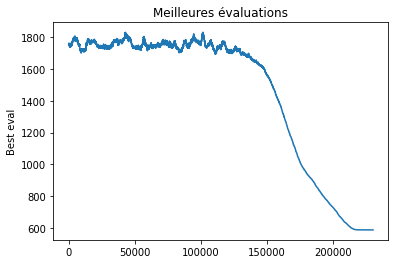

Dernière évaluation :  587.3000000000002
Somme =  14091.600000000186
Apres PASA


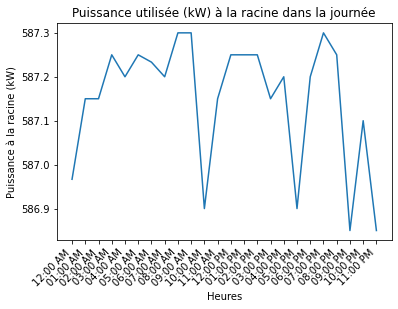

587.3000000000002
---------------------
(start, stop) = (19500, 20740)


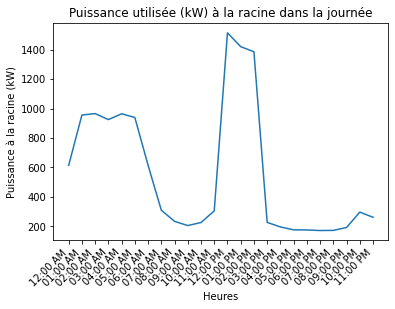

Première évaluation :  1513.6999999999964
Somme =  13450.20000000002
iter_courant :  0  // T =  1000000000.0
iter_courant :  10000  // T =  45173.345977048186
iter_courant :  20000  // T =  2.040631186762097
iter_courant :  30000  // T =  9.218213861115893e-05
iter_courant :  40000  // T =  4.164175640386101e-09
---Temps boucle PASA : 208.6590597629547 seconds ---


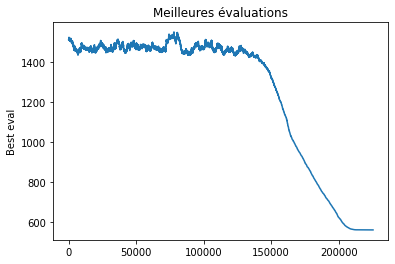

Dernière évaluation :  560.5500000000239
Somme =  13450.200000000135
Apres PASA


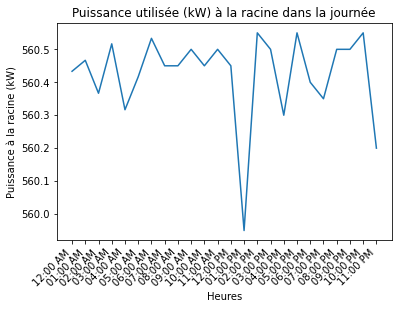

560.5500000000239
---Temps total : 4846.460342645645 seconds ---
8690.80000000019


In [19]:
res = [(0, 1500), (1500, 3000), (3000, 4500), (4500, 6000),
      (6000, 7500), (7500, 9000), (9000, 10500), (10500, 12000),
      (12000, 13500), (13500, 15000), (15000, 16500), (16500, 18000),
      (18000, 19500), (19500, 20740)]

# TODO : suppr
#res = [(0, 100)]

best_X = {}
sum_by_hour = np.zeros(shape = (24,))
best_evaluation = 0

# TODO : suppr
x = [datetime.time(i).strftime("%I:00 %p") for i in range(0, 24)]

start_time = time()
for start, stop in res:
    print("---------------------\n(start, stop) = ({}, {})".format(start, stop))
    df_equipments_short = df_equipments[start:stop]
    lst_index_logement = list(df_equipments_short.index.values)
    lst_col_equipment = list(df_equipments_short.columns.values)
    

    # Ajout des colonnes nécessaires
    df_equipments_short = add_columns_to_equipment(lst_index_logement, df_power_limits, df_equipments_short, df_info_consumption)
    
    best_x_range, sum_by_hour_range = generer_pop(lst_index_logement, new_dict_HC, 
                                                  df_equipments_short, df_info_consumption, lst_col_equipment)
    
    best_x_range, best_evaluation_range, sum_by_hour_range = PASA(best_x_range, sum_by_hour_range, 
                                                                  T0, IterMax, Tmin, Palier, Alpha, 
                                                                  lst_index_logement, new_dict_HC, df_equipments_short, 
                                                                  df_info_consumption, lst_col_equipment)

    best_X.update(best_x_range)
    sum_by_hour = np.add(sum_by_hour, sum_by_hour_range)
    best_evaluation += best_evaluation_range
    
    # TODO : suppr ?
    print("Apres PASA")
    y = list(sum_by_hour_range)
    create_fig(x, y)     
    print(best_evaluation_range)

print("---Temps total : %s seconds ---" % (time() - start_time))
print(best_evaluation)

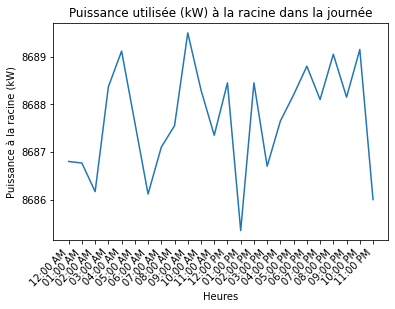

[8686.8        8686.76666667 8686.16666667 8688.36666667 8689.11666667
 8687.61666667 8686.11666667 8687.1        8687.55       8689.5
 8688.3        8687.35       8688.45       8685.35       8688.45
 8686.7        8687.65       8688.2        8688.8        8688.1
 8689.05       8688.15       8689.15       8686.        ]
total =  208504.8000000018


In [20]:
y = list(sum_by_hour)

create_fig(x, y)  
print(sum_by_hour)
print("total = ", np.sum(sum_by_hour))

In [26]:
print(len(best_X))

NameError: name 'best_X' is not defined

#### Faire une fonction qui enregistre les matrices crées

In [ ]:
#save_matrix_to_csv(best_X, df_equipments, "")

In [43]:

# TODO : suppr
x = [datetime.time(i).strftime("%I:00 %p") for i in range(0, 24)]

start_time = time()

last_df_equipments = df_equipments[:1000]
last_lst_index_logement = list(last_df_equipments.index.values)
last_lst_col_equipment = list(last_df_equipments.columns.values)


# Ajout des colonnes nécessaires
last_df_equipments = add_columns_to_equipment(last_lst_index_logement, 
                                              df_power_limits, last_df_equipments, df_info_consumption)

# premiere init
print("Générer pop ... ")
last_best_x, last_sum_by_hour = generer_pop(last_lst_index_logement, new_dict_HC, 
                                              last_df_equipments, df_info_consumption, last_lst_col_equipment)
print("Générer pop : ok")


Générer pop ... 
Générer pop : ok


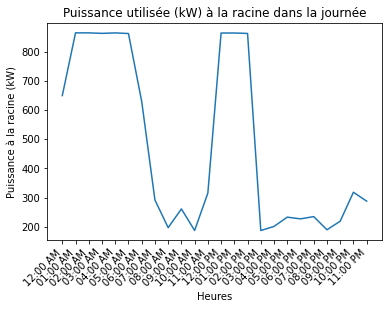

Première évaluation :  864.3166666666698
Somme =  11541.40000000006
iter_courant :  0  // T =  300
iter_courant :  100  // T =  109.8097023819687
iter_courant :  200  // T =  40.19390245738847
iter_courant :  300  // T =  14.712268221385694
iter_courant :  400  // T =  5.385165982513533
iter_courant :  500  // T =  1.971144912724377
iter_courant :  600  // T =  0.7215027873933185
iter_courant :  700  // T =  0.26409335450473737
iter_courant :  800  // T =  0.09666670886406997
iter_courant :  900  // T =  0.03538314176869316
iter_courant :  1000  // T =  0.012951374223197344
iter_courant :  1100  // T =  0.004740621829622672
iter_courant :  1200  // T =  0.001735220907387766
iter_courant :  1300  // T =  0.000635146971357401
iter_courant :  1400  // T =  0.00023248433297854985
iter_courant :  1500  // T =  8.50967847094836e-05
iter_courant :  1600  // T =  3.1148175342036186e-05
iter_courant :  1700  // T =  1.1401239546834573e-05
---Temps boucle PASA : 327.9895372390747 seconds ---


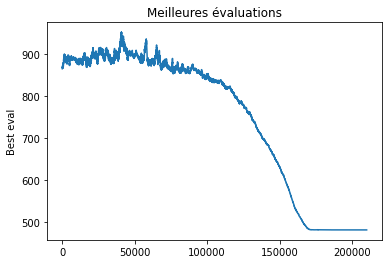

Dernière évaluation :  481.00000000001575
Somme =  11541.400000000114
Apres PASA


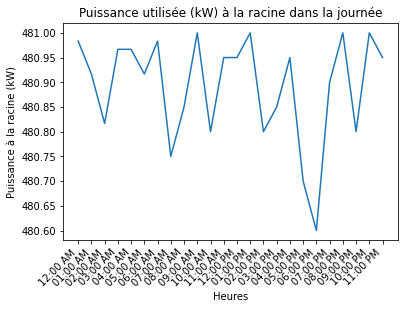

481.00000000001575
---Boucle 1 : Temps total : 408.287668466568 seconds ---


In [45]:
T0 = 300 # temperature initiale
Tmin = 1e-5 # temperature finale
tau = 1e4 # constante pour la décroissance de temperature
Alpha = 0.99 # constante pour la décroissance géométrique
Palier = 200 # nombre d'itérations sur un palier de température
IterMax = 1e6 # nombre max d'itérations de l'algorithme

# pasa 1
new_last_best_x, last_best_evaluation, last_sum_by_hour = PASA(last_best_x, last_sum_by_hour, 
                                                              T0, IterMax, Tmin, Palier, Alpha, 
                                                              last_lst_index_logement, new_dict_HC, 
                                                              last_df_equipments, 
                                                              df_info_consumption, last_lst_col_equipment)

# TODO : suppr ?
print("Apres PASA")
y = list(last_sum_by_hour)
create_fig(x, y)     
print(last_best_evaluation)
print("---Boucle 1 : Temps total : %s seconds ---" % (time() - start_time))

In [49]:
np.mean([264.29,
292.58,
345.66,
499.69,
717.44,
280.95,
217.82,
243.82,
260.22,
260.51,
308.0498,
454.21,
214.60,
208.65])

326.32070000000004

In [51]:
np.max([264.29,
292.58,
345.66,
499.69,
717.44,
280.95,
217.82,
243.82,
260.22,
260.51,
308.0498,
454.21,
214.60,
208.65])

717.44